## Importing librairies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Verification that GPU is active.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Defining global variables

In [3]:
width, height = 250, 250 # size of the images in the dataset
data_dir = r"H:\Datasets\chantiers\Train_chantiers" # path to the dataset
batch_size = 8
name_model = 'NameOfYourModel.h5' # The name of the model, it will save the weights of the model as a .h5 file if you want to use the inference later. 

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height, width),
  batch_size=batch_size)

Found 17811 files belonging to 2 classes.
Using 14249 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height, width),
  batch_size=batch_size)

Found 17811 files belonging to 2 classes.
Using 3562 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['chantier_plein', 'chantier_vide']


Defining useful functions

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def time_it(func):
    """
    Usage : Put @time_it before your function to calculate execution time.
    """
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Execution time of {func.__name__}: {end - start:.5f} seconds")
        return result
    return wrapper

Plot of some images to check that everything is going smoothly

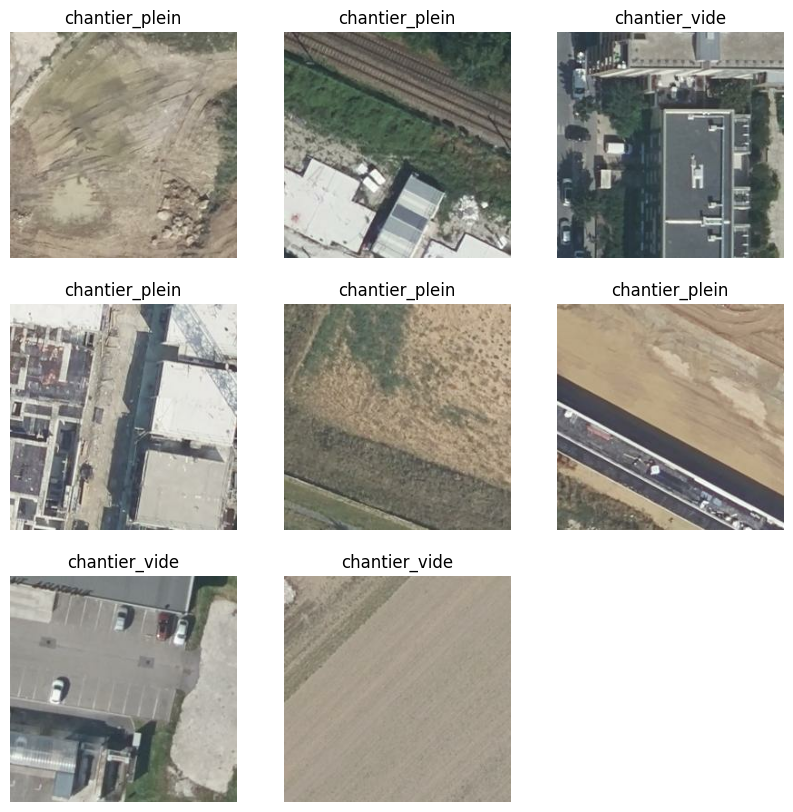

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(min(9,batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds: # Printing the shape of the dataset
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 250, 250, 3)
(8,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model definition

In [10]:
num_classes = len(class_names)
# Backbone of the model
base_model = tf.keras.applications.EfficientNetB3(input_shape=(height, width,3), include_top=False ,weights='imagenet')
base_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 250, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 250, 250, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 250, 250, 3)  0           ['normalization[0][0

In [11]:
last = base_model.output # dernière couche
x = tf.keras.layers.GlobalAveragePooling2D()(last)
# Fully connected layer
x = tf.keras.layers.Dense(4096, activation='relu')(x)
# Logistic layer (number of classes)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model1 = tf.keras.Model(base_model.input, outputs=outputs)

In [12]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=0,patience=30)
mc = ModelCheckpoint(name_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet152V2 layers
for layer in base_model.layers:
    layer.trainable = False

model1.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
# Only train top layers
epochs=20
with tf.device('/device:GPU:0'): # ensure that training is done by GPU just in case
    history = model1.fit(train_ds, validation_data=val_ds,batch_size=batch_size, epochs=epochs,verbose=1, callbacks = [es,mc])

Epoch 1/40
 216/1782 [==>...........................] - ETA: 3:25 - loss: 0.5569 - accuracy: 0.7743

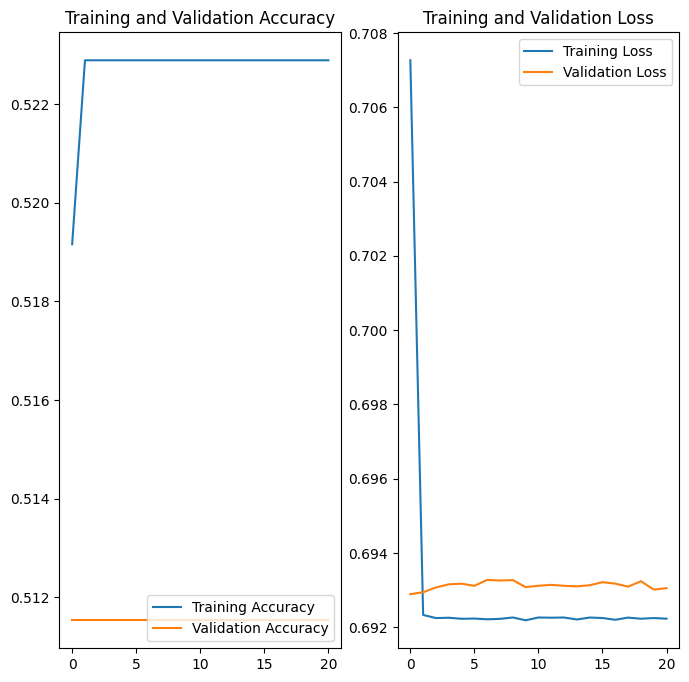

In [48]:
plot_history(history=history)

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model1.layers):
   print(i, layer.name)
print(len(model1.layers))

In [49]:
for layer in model1.layers:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
model1.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [50]:
history11 = model1.fit(train_ds, validation_data=val_ds,batch_size=batch_size, epochs=epochs,verbose=1, callbacks = [es,mc])

Epoch 1/40
369/369 [==============================] - ETA: 0s - loss: 1.5514 - accuracy: 0.7358
Epoch 1: val_accuracy did not improve from 0.84939
369/369 [==============================] - 88s 207ms/step - loss: 1.5514 - accuracy: 0.7358 - val_loss: 0.4362 - val_accuracy: 0.8412
Epoch 2/40
369/369 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.8437
Epoch 2: val_accuracy did not improve from 0.84939
369/369 [==============================] - 74s 200ms/step - loss: 0.3508 - accuracy: 0.8437 - val_loss: 0.4362 - val_accuracy: 0.8331
Epoch 3/40
369/369 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9105
Epoch 3: val_accuracy did not improve from 0.84939
369/369 [==============================] - 75s 202ms/step - loss: 0.2154 - accuracy: 0.9105 - val_loss: 0.5577 - val_accuracy: 0.8060
Epoch 4/40
369/369 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.9183
Epoch 4: val_accuracy did not improve from 0.84939
369/369 [=

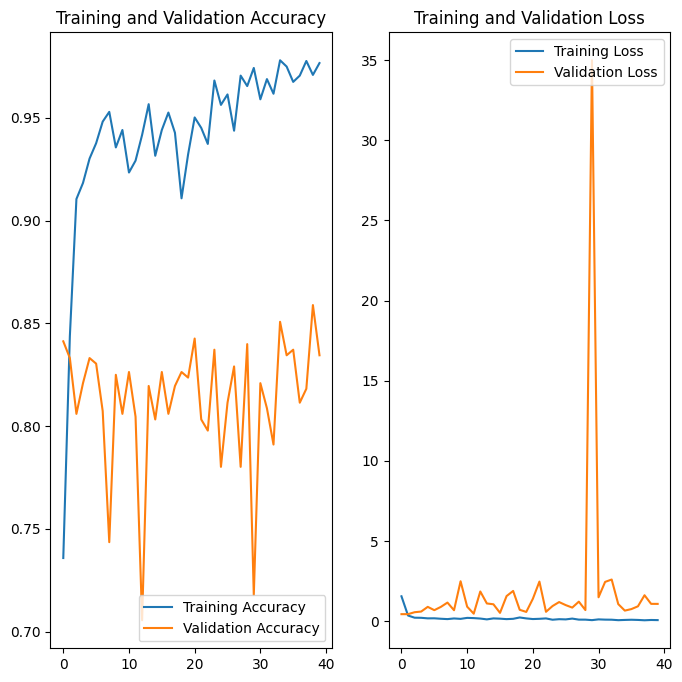

In [53]:
plot_history(history11)

In [62]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "H:/Datasets/chantiers/Test_chantiers/",
  seed=123,
  image_size=(height, width),
  batch_size=batch_size)

Found 2349 files belonging to 1 classes.


In [63]:
model1.evaluate(test_ds)

294/294 [==============================] - 13s 44ms/step - loss: 1.5098 - accuracy: 0.7735


[1.5097978115081787, 0.7735206484794617]

In [ ]:
# MIT License

# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing

# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.